In [2]:
### %reload_ext autoreload

###%reset

import numpy as np

import scipy.interpolate
from scipy.stats import poisson
from scipy.stats import uniform
from astropy import units

import matplotlib.pyplot as pl
import matplotlib

import healpy as hp
from astropy import units as u

#For making corner plots
from getdist import plots, MCSamples

import pdb
import time

import EPDFABC as epdfabc
import subhalos as subs
import FermiBackgrounds
import DMsignal

import pickle as pk

import elfi
from elfi.methods.density_ratio_estimation import DensityRatioEstimation
#import graphviz
elfi.set_client('multiprocessing')    

#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

import abc_funcs as af

matplotlib.use('PS')

%matplotlib inline

In [2]:
channel = 'b'
run = 'run3'

#For data generation
logbins = False
if (run == 'generate'):
    load_pf = True
    load_data = False
    save_data = True
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    N_E_bins = 10
    cmax_summary = 250
    
# Comparison to exact likelihood
if (run == 'run1'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    N_E_bins = 1
    nbins_summary = 20
    cmax_summary = 240
    max_iter = 5 #5
    
# Showing that adding energy info helps
if (run == 'run2'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    if (channel == 'Tau'):
        N_E_bins = 10
        nbins_summary = 15
        cmax_summary = 75
        max_iter = 5
    if (channel == 'b'):
        N_E_bins = 10
        nbins_summary = 10
        cmax_summary = 120 
        max_iter = 1

# Varying DM mass as well
if (run == 'run3'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = True
    N_E_bins = 10
    nbins_summary = 15
    cmax_summary = 75 # 70 - for tau
    max_iter = 4 #4

if (channel == 'Tau'):
    suffix = 'tau_default_NE10_MMin1_10yr'
    if (run == 'run3'):
        normalize_mean = [200., 1., 200000.]
        normalize_std = [100.0, 0.01, 10000.0]    
    else:
        normalize_mean = [0.0, 0.0, 0.0]
        normalize_std = [1.0, 1.0, 1.0] 
        
if (channel == 'b'):
    suffix = 'b_default_NE10_MMin1_10yr'
    if (run == 'run3'):
        normalize_mean = [6., 1., 50000]
        normalize_std = [1.0, 0.01, 1000.0]    
    else:
        normalize_mean = [0.0, 0.0, 0.0]
        normalize_std = [1.0, 1.0, 1.0]  

In [3]:
#parameter ranges
DM_directory = './data/dm_spectra/'
my_DM = DMsignal.DMsignal(DM_directory, channel)
default_param_dict = my_DM.get_default_model()
default_params = np.array([default_param_dict['A_DM'],\
                           default_param_dict['A_BG'],\
                           default_param_dict['mass_DM_MeV']])
print("default params = ", default_param_dict)

if (channel == 'Tau'):    
    param_min_all = np.array([0.2, 0.99, 0.1])*default_params
    param_max_all = np.array([2.5, 1.01, 1.9])*default_params                
if (channel == 'b'):
    param_min_all = np.array([0.4, 0.993, 0.1])*default_params
    param_max_all = np.array([1.7, 1.007, 1.9])*default_params  

param_min_all_norm = af.params_to_norm(param_min_all, normalize_mean, normalize_std)
param_max_all_norm = af.params_to_norm(param_max_all, normalize_mean, normalize_std)
print(param_min_all_norm)
print(param_max_all_norm)

param_names_all = np.array(['ADM', 'bgnorm', 'MDM'])
param_labels_all = np.array(['\\A_{DM}', '\\A_{\rm bg}', '\\M_{\chi}'])

if (not include_bg):
    free_indices = np.array([0])
else:
    if (not vary_DMmass):
        free_indices = np.array([0,1])
    else:
        free_indices = np.array([0,1,2])
true_params = default_params[free_indices]   
param_names = param_names_all[free_indices]
param_labels = param_labels_all[free_indices]
param_min = param_min_all[free_indices]
param_max = param_max_all[free_indices]
param_range = [param_min, param_max]
param_min_norm = param_min_all_norm[free_indices]
param_max_norm = param_max_all_norm[free_indices]
param_range_norm = [param_min_norm, param_max_norm]

print("free params = ", param_names)

default params =  {'A_DM': 5.0, 'A_BG': 1.0, 'mass_DM_MeV': 50000.0}
[ -4.   -0.7 -45. ]
[ 2.5  0.7 45. ]
free params =  ['ADM' 'bgnorm' 'MDM']


In [4]:
#Properties of summary statistic <---needs updating for unbinned
if (channel == 'Tau'):
    energy_bins_to_use = 'all'
if (channel == 'b'):
    energy_bins_to_use = np.array([0,1,2,3,4,5,6])
    cmax_summary = np.array([120, 70, 50, 30, 20, 10,10])
summary_properties = {'type': 'histogram' ,'Nbins':nbins_summary, \
                      'Cmax_hist': cmax_summary, 'Cmin_hist': 0, 'logbins':logbins, \
                      'energy_bins_to_use':energy_bins_to_use}

In [5]:
# Settings for subhalo analysis
physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')
print(physics_settings)
print(obs_settings)

default_phipp = physics_settings['PhiPP']
N_pix = int(4.*np.pi/obs_settings['Omega_pixel'])
N_side = int(np.sqrt(N_pix/12.0))

exposure = obs_settings['obs_time']*obs_settings['area']*obs_settings['fov_factor']
#Sangle = obs_settings['Omega_pixel']

print("N_side = ", N_side)

{'R_G': 220, 'd_sun': 8.5, 'M_max': 10000000000.0, 'M_min': 1.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9}
{'area': 2000.0, 'obs_time': 10.0, 'fov_factor': 0.2, 'Omega_pixel': 0.00025566346464760684, 'psi': 1.7453292519943295}
N_side =  64


In [6]:
#setup EPDFABC object

#mass should be in units of solar mass, radius should be in kpc
def mass_profile(input_params, mass, radius):
    Rs = 21 #scale radius in kpc
    beta = 1.9
    A = 1.2e4
    return A*mass**(-beta)/((radius/Rs)*(1+(radius/Rs))**2)

#mass should be in units of solar mass, radius should be in kpc
def luminosity(input_params, mass, radius):
    meanL = 77.4+0.87*np.log(mass/1e5)-0.23*np.log(radius/50)
    sig = 0.74-0.0030*np.log(mass/1e5)-0.011*np.log(radius/50)
    return meanL, sig

def spectrum(input_params, energy):
    DM_mass = input_params[2]
    return my_DM.get_dNdE(energy, channel, DM_mass)

abun_lum_spec = np.array([[mass_profile, luminosity, spectrum]])
energy_range = [1000, 100000] #this is in MeV
mass_range = [1.0e3, 1.0e10]
Rs = 21 #scale radius in kpc
radius_range = [0.35*Rs, 10*Rs] #in kpc
is_isotropic_list = [True]

my_abc = epdfabc.EPDFABC(param_range)
my_abc.setup_unbinned(abun_lum_spec, is_isotropic_list, energy_range, mass_range, radius_range, exposure, verbose = False)

In [7]:
#Backgrounds

# Energy spectrum setup
#We use FermiBackgrounds to get the background spectrum and mean flux
fermi_data_path = './data/FermiData/'
background_generator = FermiBackgrounds.FermiBackgrounds(fermi_data_path)
fermi_iso = background_generator.get_isotropic_background_spectrum_func()
mean_iso_bg_flux = background_generator.get_mean_isotropic_flux(energy_range[0], energy_range[1])

(array([24, 23, 29, ..., 31, 19, 23]), array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 4.9150e+04, 4.9151e+04,
       4.9152e+04]))
49152
49152


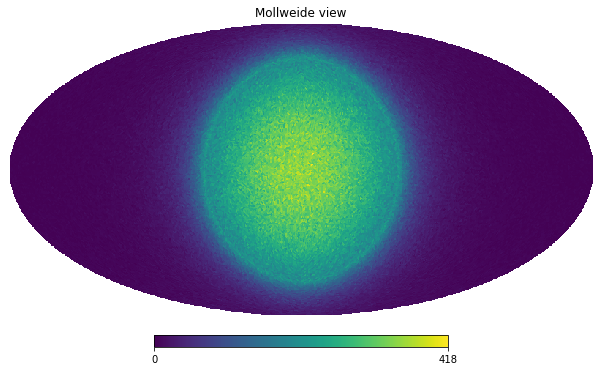

In [8]:
#create sources
input_params = (param_min+param_max)/2
source_info = my_abc.create_sources(input_params)
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), 
                       bins = N_pix, range = [0.0, N_pix])
print(heatmap)
print(np.size(heatmap[0]))
print(N_pix)
hp.mollview(heatmap[0])


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
dict_keys(['maxc', 'pc', 'counts', 'f_pf_precomputed', 'pf_pf_precomputed', 'physics_settings', 'fft_settings', 'obs_settings'])
(array([0, 2, 0, ..., 1, 0, 0]), array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 4.9150e+04, 

(array([7.8797e+04, 3.0520e+04, 1.4756e+04, 7.9380e+03, 4.6450e+03,
        2.8020e+03, 1.8130e+03, 1.1250e+03, 7.6100e+02, 5.5400e+02,
        3.9600e+02, 2.7500e+02, 1.9800e+02, 1.3400e+02, 1.0400e+02,
        8.7000e+01, 6.0000e+01, 5.1000e+01, 3.6000e+01, 2.9000e+01,
        1.5000e+01, 2.0000e+01, 1.0000e+01, 1.4000e+01, 4.0000e+00,
        9.0000e+00, 4.0000e+00, 7.0000e+00, 6.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

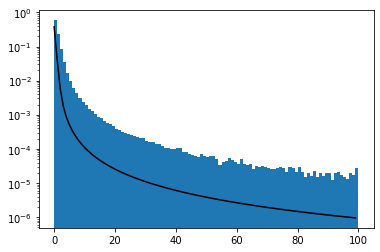

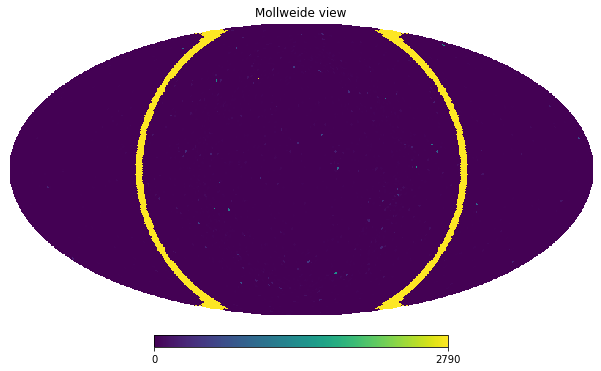

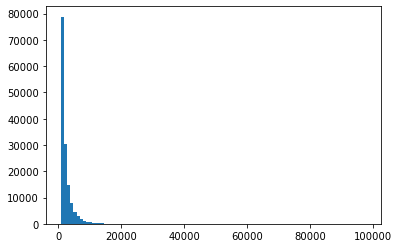

In [9]:
#create photons
vec = hp.ang2vec(np.pi/2, 0)
min_disc = hp.query_disc(nside=N_side, vec=vec, radius=np.radians(98))
max_disc = hp.query_disc(nside=N_side, vec=vec, radius=np.radians(102))
ring = np.setdiff1d(max_disc, min_disc)

many_maps = np.array([])
for i in range(1000):
    if i%5==0:
        print(i)
    source_info = my_abc.create_sources(input_params)
    photon_info = my_abc.generate_photons_from_sources(input_params, source_info)
    heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), 
                           bins = N_pix, range = [0.0, N_pix])
    many_maps = np.concatenate((many_maps, heatmap[0][ring]))
amputated_maps = many_maps[np.where(many_maps<101)]
testdata = pk.load(open('./data/Test_Data/pf_and_pc_for_test.pk','rb'))
print(testdata.keys())
fig, ax = pl.subplots(1,1)
ax.plot(testdata['counts'], testdata['pc'], 'k-')
ax.hist(amputated_maps, bins = 100, density = True)
ax.set_yscale('log')

print(heatmap)
print(np.size(heatmap[0]))
print(N_pix)
heatmap[0][ring] = heatmap[0].max()
hp.mollview(heatmap[0])

fig, ax = pl.subplots(1,1)
ax.hist(photon_info['energies'], bins=100)

[2507.01522238 1415.00419196 1834.00842433 ... 5388.04432368 1041.00041415
 1210.00212123]
(array([ 1,  0, 21, ...,  2,  1,  1]), array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 4.9150e+04, 4.9151e+04,
       4.9152e+04]))
49152
49152
None


(array([6.0178e+04, 4.3433e+04, 1.8547e+04, 9.2470e+03, 5.1150e+03,
        3.0550e+03, 1.8330e+03, 1.1600e+03, 7.5800e+02, 5.1100e+02,
        3.7600e+02, 2.5300e+02, 1.8900e+02, 1.2800e+02, 9.1000e+01,
        7.4000e+01, 5.0000e+01, 4.9000e+01, 3.4000e+01, 1.8000e+01,
        1.9000e+01, 1.3000e+01, 6.0000e+00, 1.0000e+01, 5.0000e+00,
        5.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00, 5.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

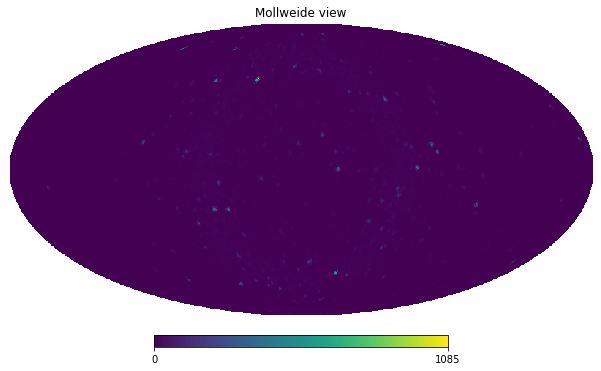

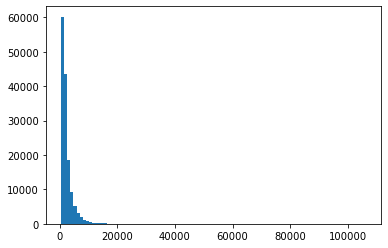

In [10]:
#Smear photon angles and energies
print(photon_info['energies'])

angle_res = 0.01
energy_res = 0.3
smeared_photon_info = my_abc.PSF_energy_dispersion(photon_info, angle_res, energy_res)
heatmap = np.histogram(hp.ang2pix(N_side, smeared_photon_info['angles'][:,0], smeared_photon_info['angles'][:,1]), 
                       bins = N_pix, range = [0.0, N_pix])
print(heatmap)
print(np.size(heatmap[0]))
print(N_pix)
print(hp.mollview(heatmap[0]))

fig, ax = pl.subplots(1,1)
ax.hist(smeared_photon_info['energies'], bins=100)

78962.0
1004102
1710000
1707614
0.998604678362573
1.0003061262190789
8.403318463167745e-06
[5.87194152e-01 2.34161404e-01 8.37701754e-02 3.44959064e-02
 1.71906433e-02 9.74678363e-03 6.28304094e-03 4.28421053e-03
 3.13391813e-03 2.44561404e-03 1.86959064e-03 1.52456140e-03
 1.25847953e-03 1.07368421e-03 8.75438596e-04 8.02923977e-04
 6.69005848e-04 5.71345029e-04 5.25730994e-04 4.70175439e-04
 3.90058480e-04 3.64912281e-04 3.12280702e-04 2.87719298e-04
 2.70175439e-04 2.48538012e-04 2.30994152e-04 2.17543860e-04
 2.01754386e-04 2.02923977e-04 1.76023392e-04 1.57894737e-04
 1.63157895e-04 1.40935673e-04 1.41520468e-04 1.21052632e-04
 1.08771930e-04 1.06432749e-04 9.94152047e-05 9.70760234e-05
 1.08771930e-04 1.05263158e-04 8.07017544e-05 8.36257310e-05
 7.01754386e-05 6.60818713e-05 6.08187135e-05 5.96491228e-05
 7.01754386e-05 6.37426901e-05 5.67251462e-05 6.08187135e-05
 6.02339181e-05 5.20467836e-05 3.27485380e-05 4.09356725e-05
 4.38596491e-05 5.43859649e-05 4.61988304e-05 4.2105263

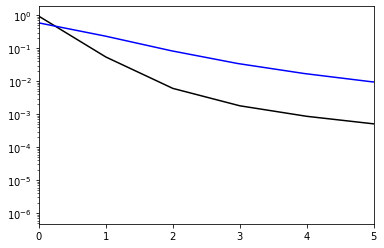

In [64]:
many_maps = pk.load(open('./data/Test_Data/many_maps.pk','rb'))
#amputated_maps = pk.load(open('./data/Test_Data/amputated_maps.pk','rb'))
amputated_maps = many_maps[np.where(many_maps<100)]
testdata = pk.load(open('./data/Test_Data/pf_and_pc_for_test_v02.pk','rb'))
fig, ax = pl.subplots(1,1)
ax.plot(testdata['counts'], testdata['pc'], 'k-')
many_hist, many_bins = np.histogram(many_maps, bins = int(max(many_maps)))
amputated_hist, amputated_bins = np.histogram(amputated_maps, bins = 100)
ax.plot(amputated_bins[:-1], amputated_hist/np.sum(many_hist), 'b-')
#ax.hist(amputated_maps, bins = 100, density = True)
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim([0.,5.])
print(sum(many_hist))
print(sum(amputated_hist))
print(sum(amputated_hist)/sum(many_hist))
print(np.sum(testdata['pc']))

# 